Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

### L2 regularization for logistic

In [5]:
def run_logistic_graph(l2_beta):
    batch_size = 128

    graph = tf.Graph()
    with graph.as_default():
        tf_train_dataset = tf.placeholder(tf.float32,
                                          shape=(batch_size, image_size * image_size))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)

        weights = tf.Variable(
            tf.truncated_normal([image_size * image_size, num_labels]))
        biases = tf.Variable(tf.zeros([num_labels]))

        logits = tf.matmul(tf_train_dataset, weights) + biases
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
        # note that we don't impose a penalty on the biases -- only on the weights.
        loss = loss + l2_beta * tf.nn.l2_loss(weights)

        optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

        train_prediction = tf.nn.softmax(logits)
        valid_prediction = tf.nn.softmax(
            tf.matmul(tf_valid_dataset, weights) + biases)
        test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

    num_steps = 3001

    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict)
        valid_accuracy = accuracy(valid_prediction.eval(), valid_labels)
        test_accuracy = accuracy(test_prediction.eval(), test_labels)
        return valid_accuracy, test_accuracy

Let's try several different values of $\beta$.

In [6]:
for beta in [0.0, 0.001, 0.002, 0.003, 0.004, 0.01]:
    valid_acc, test_acc = run_logistic_graph(beta)
    print("For beta of {0:.3f}: {1:.1f}% {2:.1f}%".format(beta, valid_acc, test_acc))

For beta of 0.000: 78.8% 86.5%
For beta of 0.001: 81.9% 89.0%
For beta of 0.002: 82.0% 89.1%
For beta of 0.003: 81.7% 89.0%
For beta of 0.004: 81.7% 89.0%
For beta of 0.010: 81.4% 88.6%


Looks like we got best results with a $\beta$ of 0.002.

### L2 regularization for nn

In [7]:
def run_nn_graph(l2_beta, num_steps=3001, keep_prob=1.0):
    batch_size = 128
    num_hidden_nodes = 1024

    graph = tf.Graph()
    with graph.as_default():
        tf_train_dataset = tf.placeholder(
            tf.float32, shape=(batch_size, image_size * image_size))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)

        # Variables.
        weights_0 = tf.Variable(
            tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
        biases_0 = tf.Variable(tf.zeros([num_hidden_nodes]))
        weights_1 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
        biases_1 = tf.Variable(tf.zeros([num_labels]))

        # Training computation.
        logits_0 = tf.matmul(tf_train_dataset, weights_0) + biases_0
        if keep_prob != 1.0:
            logits_0 = tf.nn.dropout(logits_0, keep_prob)
        logits_1 = tf.matmul(tf.nn.relu(logits_0), weights_1) + biases_1
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits_1))
        loss = loss + l2_beta * (tf.nn.l2_loss(weights_0) + tf.nn.l2_loss(weights_1))

        # Optimizer.
        optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits_1)

        def prediction_for_dataset(dataset):
            l0 = tf.matmul(dataset, weights_0) + biases_0
            l1 = tf.matmul(tf.nn.relu(l0), weights_1) + biases_1
            return tf.nn.softmax(l1)

        valid_prediction = prediction_for_dataset(tf_valid_dataset)
        test_prediction = prediction_for_dataset(tf_test_dataset)

    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict)
        valid_accuracy = accuracy(valid_prediction.eval(), valid_labels)
        test_accuracy = accuracy(test_prediction.eval(), test_labels)
        return valid_accuracy, test_accuracy

In [9]:
for beta in [0.0, 0.001, 0.0013, 0.0015, 0.0018, 0.002]:
    valid_acc, test_acc = run_nn_graph(beta)
    print("For beta of {0:.5f}: {1:.1f}% {2:.1f}%".format(beta, valid_acc, test_acc))

For beta of 0.00000: 82.5% 89.5%
For beta of 0.00100: 86.6% 92.8%
For beta of 0.00130: 86.6% 93.2%
For beta of 0.00150: 86.7% 93.1%
For beta of 0.00180: 86.5% 93.1%
For beta of 0.00200: 86.5% 92.9%


---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [10]:
_, test_acc = run_nn_graph(0, 3)
print("Accuracy of {0:.1f}%".format(test_acc))

Accuracy of 41.6%


---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [11]:
for keep_prob in [0.5, 0.7, 0.8, 0.83, 0.85, 0.87, 0.9, 0.92, 0.95]:
    valid_acc, test_acc = run_nn_graph(0.0, keep_prob=keep_prob)
    print("For keep prob of {0:.5f}: {1:.1f}% {2:.1f}%".format(keep_prob, valid_acc, test_acc))

For keep prob of 0.50000: 80.1% 87.7%
For keep prob of 0.70000: 81.2% 88.8%
For keep prob of 0.80000: 81.4% 88.8%
For keep prob of 0.83000: 81.6% 89.0%
For keep prob of 0.85000: 81.9% 88.9%
For keep prob of 0.87000: 81.2% 89.0%
For keep prob of 0.90000: 82.3% 89.0%
For keep prob of 0.92000: 81.8% 89.5%
For keep prob of 0.95000: 81.6% 89.1%


In [12]:
for keep_prob in [0.5, 0.7, 0.8, 0.83, 0.85, 0.87, 0.9, 0.92, 0.95]:
    valid_acc, test_acc = run_nn_graph(0, num_steps=3, keep_prob=keep_prob)
    print("For keep prob of {0:.5f}: {1:.1f}% {2:.1f}%".format(keep_prob, valid_acc, test_acc))

For keep prob of 0.50000: 46.3% 50.6%
For keep prob of 0.70000: 34.3% 37.4%
For keep prob of 0.80000: 28.1% 29.4%
For keep prob of 0.83000: 46.0% 50.5%
For keep prob of 0.85000: 42.1% 45.3%
For keep prob of 0.87000: 29.9% 31.8%
For keep prob of 0.90000: 41.3% 45.0%
For keep prob of 0.92000: 33.8% 36.9%
For keep prob of 0.95000: 42.4% 46.8%


---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [26]:
batch_size = 128

def run_big_nn_graph(hidden_layer_sizes, 
                     l2_beta=0.0,
                     num_steps=3001, 
                     input_keep_prob=1.0,
                     hidden_keep_prob=1.0,
                     clip_norm=None,
                     starter_learning_rate=0.1, 
                     decay_steps=128, 
                     decay_rate=0.95):

    graph = tf.Graph()
    with graph.as_default():
        tf_train_dataset = tf.placeholder(
            tf.float32, shape=(batch_size, image_size * image_size))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)

        # Variables and Training Computation
        layer_input = tf_train_dataset
        layer_input_cols = image_size * image_size
        hidden_layers = []
        for i, hidden_layer_size in enumerate(hidden_layer_sizes):
            weight_dim = [layer_input_cols, hidden_layer_size]
            print("hidden layer {0} will have weight dimensions {1}".format(i, weight_dim))
            weights = tf.get_variable(
                "W{0}".format(i), shape=weight_dim, 
                initializer=tf.contrib.layers.variance_scaling_initializer())
            if clip_norm is not None:
                weights = tf.clip_by_norm(weights, clip_norm, axes=[1])
            biases = tf.Variable(tf.zeros([hidden_layer_size]))
            hidden_layers.append((weights, biases))
            if i == 0 and input_keep_prob != 1.0:
                layer_input = tf.nn.dropout(layer_input, input_keep_prob)
            elif i > 0 and hidden_keep_prob != 1.0:
                layer_input = tf.nn.dropout(layer_input, hidden_keep_prob)
            layer_input = tf.nn.relu(tf.matmul(layer_input, weights) + biases)
            layer_input_cols = hidden_layer_size
        weights = tf.get_variable(
                "W", shape=[layer_input_cols, num_labels], 
                initializer=tf.contrib.layers.variance_scaling_initializer())
        if clip_norm is not None:
            weights = tf.clip_by_norm(weights, clip_norm, axes=[1])
        biases = tf.Variable(tf.zeros([num_labels]))
        if hidden_keep_prob != 1.0:
            layer_input = tf.nn.dropout(layer_input, hidden_keep_prob)
        logits = tf.matmul(layer_input, weights) + biases
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
        if l2_beta != 0.0:
            all_weights = [l[0] for l in hidden_layers] + [weights]
            loss = loss + l2_beta * sum(tf.nn.l2_loss(w) for w in all_weights)

        # Optimizer.
        global_step = tf.Variable(0)
        learning_rate = tf.train.exponential_decay(
            starter_learning_rate, global_step, decay_steps, decay_rate)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)

        def prediction_for_dataset(dataset):
            layer_input = dataset
            for h_weights, h_biases in hidden_layers:
                layer_input = tf.nn.relu(tf.matmul(layer_input, h_weights) + h_biases)
            return tf.nn.softmax(tf.matmul(layer_input, weights) + biases)

        valid_prediction = prediction_for_dataset(tf_valid_dataset)
        test_prediction = prediction_for_dataset(tf_test_dataset)

    training_nums = []
    
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (step % 500 == 0):
                training_accuracy = accuracy(predictions, batch_labels)
                validation_accuracy = accuracy(valid_prediction.eval(), valid_labels)
                learning_rate_eval = learning_rate.eval()
                training_nums.append(dict(
                    step=step,
                    learning_rate=learning_rate_eval,
                    loss=l,
                    training_accuracy=training_accuracy,
                    validation_accuracy=validation_accuracy
                ))
                print("{0} {1:.5f} {2:.1f} | ".format(step, learning_rate_eval, validation_accuracy), end='', flush=True)
        print("")
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
        return training_nums

I wanted to call especial attention to the choice of initial weights:

```python
weights = tf.get_variable(
    "W{0}".format(i), shape=weight_dim, 
    initializer=tf.contrib.layers.variance_scaling_initializer())
```

This is based on a recommendation I found in [the Stanford course](http://cs231n.github.io/neural-networks-2/). In case you're interested in the original paper: https://arxiv.org/pdf/1502.01852v1.pdf .

First, let's try it with a simple nn configuration: just one hidden layer, similar to what we've already done:

In [19]:
training_nums = run_big_nn_graph([1024], l2_beta=0.001, starter_learning_rate=0.5, decay_rate=1.0)

hidden layer 0 will have weight dimensions [784, 1024]
0 0.50000 25.5 | 500 0.50000 85.6 | 1000 0.50000 86.4 | 1500 0.50000 87.3 | 2000 0.50000 87.4 | 2500 0.50000 87.3 | 3000 0.50000 87.6 | 
Test accuracy: 93.7%


That looks consistent with our previous results! Let's look at the graphs for loss, training accuracy, and validation accuracy.

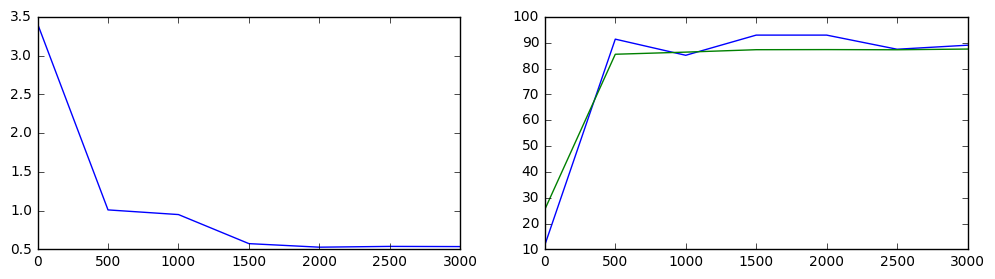

In [20]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (12.0, 3.0)

def plot_training_nums(training_nums):
    fig, axs = plt.subplots(1, 2)
    axs[0].plot([tn['step'] for tn in training_nums], [tn['loss'] for tn in training_nums])
    axs[1].plot([tn['step'] for tn in training_nums], [tn['training_accuracy'] for tn in training_nums])
    axs[1].plot([tn['step'] for tn in training_nums], [tn['validation_accuracy'] for tn in training_nums])
    plt.show()

plot_training_nums(training_nums)

Now let's try with two hidden layers. I'm also switching from l2 regularization to [dropout regularization](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf), but I'm not imposing a max-norm constraint yet. 

hidden layer 0 will have weight dimensions [784, 1024]
hidden layer 1 will have weight dimensions [1024, 1024]
0 0.49999 26.4 | 500 0.49503 84.0 | 1000 0.49012 84.9 | 1500 0.48526 86.0 | 2000 0.48045 86.3 | 2500 0.47569 86.5 | 3000 0.47097 87.0 | 
Test accuracy: 93.4%


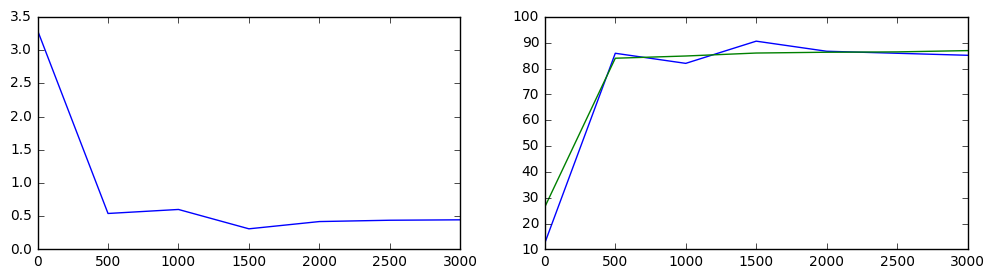

In [22]:
plot_training_nums(run_big_nn_graph(
    [1024, 1024], 
    input_keep_prob=0.8,
    hidden_keep_prob=0.5,
    starter_learning_rate=0.5, 
    decay_rate=0.96, 
    decay_steps=2048))

Interesting. Note this isn't as good as using l2 regularization:

hidden layer 0 will have weight dimensions [784, 1024]
hidden layer 1 will have weight dimensions [1024, 1024]
0 0.49999 19.7 | 500 0.49503 86.4 | 1000 0.49012 87.1 | 1500 0.48526 88.1 | 2000 0.48045 88.8 | 2500 0.47569 88.9 | 3000 0.47097 89.3 | 
Test accuracy: 94.9%


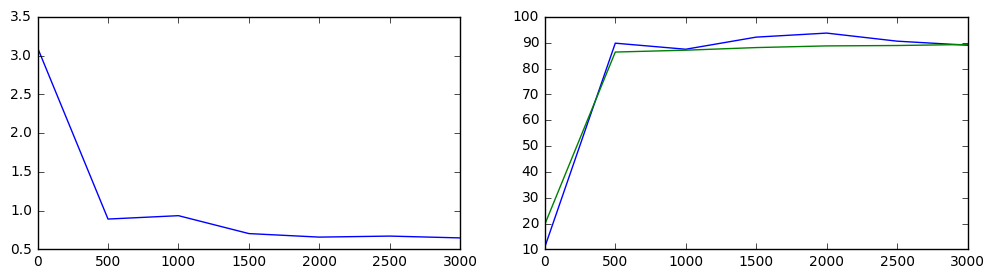

In [23]:
plot_training_nums(run_big_nn_graph(
    [1024, 1024], 
    l2_beta=0.0003,
    starter_learning_rate=0.5, 
    decay_rate=0.96, 
    decay_steps=2048))

This is my best result so far. Let's go back to dropout but with a steeper learning rate dropoff.

hidden layer 0 will have weight dimensions [784, 1024]
hidden layer 1 will have weight dimensions [1024, 1024]
0 0.49996 14.9 | 500 0.48042 83.7 | 1000 0.46165 84.3 | 1500 0.44360 85.0 | 2000 0.42627 86.5 | 2500 0.40961 86.2 | 3000 0.39360 86.5 | 
Test accuracy: 93.1%


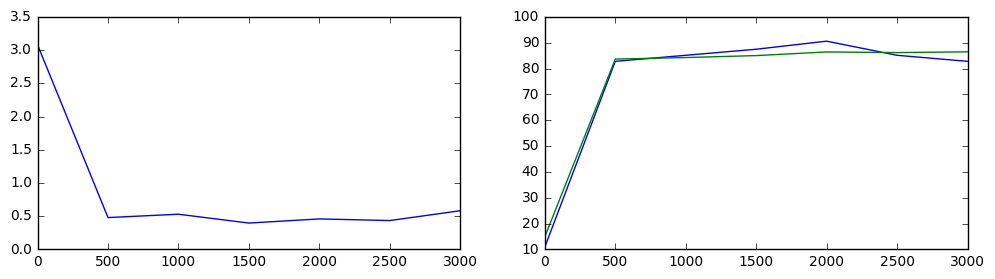

In [24]:
plot_training_nums(run_big_nn_graph(
    [1024, 1024], 
    input_keep_prob=0.8,
    hidden_keep_prob=0.5,
    starter_learning_rate=0.5, 
    decay_rate=0.96, 
    decay_steps=512))

Okay, back to old `decay_steps` param but now with a `clip_norm` of `1.0`.

hidden layer 0 will have weight dimensions [784, 1024]
hidden layer 1 will have weight dimensions [1024, 1024]
0 0.49999 21.4 | 500 0.49503 84.5 | 1000 0.49012 85.3 | 1500 0.48526 86.2 | 2000 0.48045 86.8 | 2500 0.47569 86.9 | 3000 0.47097 87.4 | 
Test accuracy: 93.7%


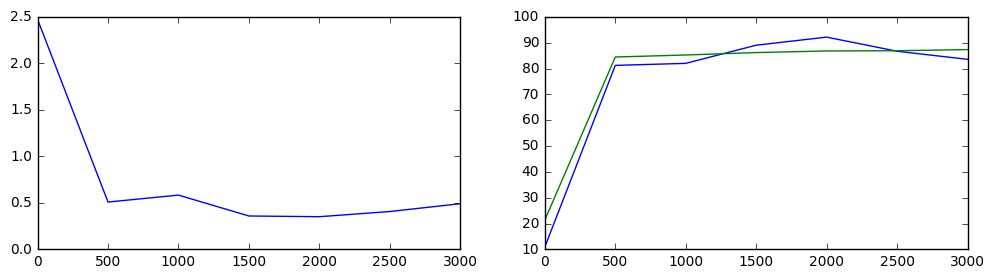

In [27]:
plot_training_nums(run_big_nn_graph(
    [1024, 1024], 
    input_keep_prob=0.8,
    hidden_keep_prob=0.5,
    clip_norm=1.0,
    starter_learning_rate=0.5, 
    decay_rate=0.96, 
    decay_steps=2048))

Let's try many different values.

In [31]:
for clip_norm in [0.3, 1.0, 3.0, 10.0]:
    print("clip_norm of {0}".format(clip_norm))
    run_big_nn_graph(
        [1024, 1024], 
        input_keep_prob=0.8,
        hidden_keep_prob=0.5,
        clip_norm=clip_norm,
        starter_learning_rate=0.5, 
        decay_rate=0.96, 
        decay_steps=2048)

clip_norm of 0.3
hidden layer 0 will have weight dimensions [784, 1024]
hidden layer 1 will have weight dimensions [1024, 1024]
0 0.49999 14.4 | 500 0.49503 81.9 | 1000 0.49012 83.2 | 1500 0.48526 84.1 | 2000 0.48045 84.6 | 2500 0.47569 84.6 | 3000 0.47097 84.8 | 
Test accuracy: 91.6%
clip_norm of 1.0
hidden layer 0 will have weight dimensions [784, 1024]
hidden layer 1 will have weight dimensions [1024, 1024]
0 0.49999 24.4 | 500 0.49503 84.2 | 1000 0.49012 85.1 | 1500 0.48526 86.1 | 2000 0.48045 86.8 | 2500 0.47569 87.1 | 3000 0.47097 87.0 | 
Test accuracy: 93.6%
clip_norm of 3.0
hidden layer 0 will have weight dimensions [784, 1024]
hidden layer 1 will have weight dimensions [1024, 1024]
0 0.49999 21.3 | 500 0.49503 84.1 | 1000 0.49012 85.0 | 1500 0.48526 85.2 | 2000 0.48045 86.2 | 2500 0.47569 86.0 | 3000 0.47097 86.8 | 
Test accuracy: 93.0%
clip_norm of 10.0
hidden layer 0 will have weight dimensions [784, 1024]
hidden layer 1 will have weight dimensions [1024, 1024]
0 0.49999 21.

Okay, a little more investigation for radii that work:

In [32]:
for clip_norm in [0.8, 1.0, 1.2, 1.4]:
    print("clip_norm of {0}".format(clip_norm))
    run_big_nn_graph(
        [1024, 1024], 
        input_keep_prob=0.8,
        hidden_keep_prob=0.5,
        clip_norm=clip_norm,
        starter_learning_rate=0.5, 
        decay_rate=0.96, 
        decay_steps=2048)

clip_norm of 0.8
hidden layer 0 will have weight dimensions [784, 1024]
hidden layer 1 will have weight dimensions [1024, 1024]
0 0.49999 27.6 | 500 0.49503 84.0 | 1000 0.49012 85.0 | 1500 0.48526 85.8 | 2000 0.48045 86.6 | 2500 0.47569 87.0 | 3000 0.47097 87.3 | 
Test accuracy: 93.6%
clip_norm of 1.0
hidden layer 0 will have weight dimensions [784, 1024]
hidden layer 1 will have weight dimensions [1024, 1024]
0 0.49999 24.9 | 500 0.49503 84.4 | 1000 0.49012 85.2 | 1500 0.48526 86.1 | 2000 0.48045 86.8 | 2500 0.47569 87.0 | 3000 0.47097 87.4 | 
Test accuracy: 93.6%
clip_norm of 1.2
hidden layer 0 will have weight dimensions [784, 1024]
hidden layer 1 will have weight dimensions [1024, 1024]
0 0.49999 11.5 | 500 0.49503 84.2 | 1000 0.49012 85.2 | 1500 0.48526 86.1 | 2000 0.48045 86.8 | 2500 0.47569 86.8 | 3000 0.47097 87.4 | 
Test accuracy: 93.4%
clip_norm of 1.4
hidden layer 0 will have weight dimensions [784, 1024]
hidden layer 1 will have weight dimensions [1024, 1024]
0 0.49999 21.9

One more level of detail before stopping:

In [33]:
for clip_norm in [0.7, 0.8, 0.9, 1.0]:
    print("clip_norm of {0}".format(clip_norm))
    run_big_nn_graph(
        [1024, 1024], 
        input_keep_prob=0.8,
        hidden_keep_prob=0.5,
        clip_norm=clip_norm,
        starter_learning_rate=0.5, 
        decay_rate=0.96, 
        decay_steps=2048)

clip_norm of 0.7
hidden layer 0 will have weight dimensions [784, 1024]
hidden layer 1 will have weight dimensions [1024, 1024]
0 0.49999 22.6 | 500 0.49503 83.9 | 1000 0.49012 85.0 | 1500 0.48526 85.9 | 2000 0.48045 86.4 | 2500 0.47569 86.7 | 3000 0.47097 86.9 | 
Test accuracy: 93.2%
clip_norm of 0.8
hidden layer 0 will have weight dimensions [784, 1024]
hidden layer 1 will have weight dimensions [1024, 1024]
0 0.49999 22.8 | 500 0.49503 84.0 | 1000 0.49012 84.8 | 1500 0.48526 85.9 | 2000 0.48045 86.6 | 2500 0.47569 87.1 | 3000 0.47097 87.2 | 
Test accuracy: 93.5%
clip_norm of 0.9
hidden layer 0 will have weight dimensions [784, 1024]
hidden layer 1 will have weight dimensions [1024, 1024]
0 0.49999 25.5 | 500 0.49503 84.2 | 1000 0.49012 84.9 | 1500 0.48526 86.0 | 2000 0.48045 86.8 | 2500 0.47569 87.1 | 3000 0.47097 87.3 | 
Test accuracy: 93.7%
clip_norm of 1.0
hidden layer 0 will have weight dimensions [784, 1024]
hidden layer 1 will have weight dimensions [1024, 1024]
0 0.49999 22.3

Going to try dropout with l2.

hidden layer 0 will have weight dimensions [784, 1024]
hidden layer 1 will have weight dimensions [1024, 1024]
0 0.49999 37.8 | 500 0.49503 83.7 | 1000 0.49012 84.6 | 1500 0.48526 86.3 | 2000 0.48045 86.5 | 2500 0.47569 86.8 | 3000 0.47097 87.2 | 
Test accuracy: 93.4%


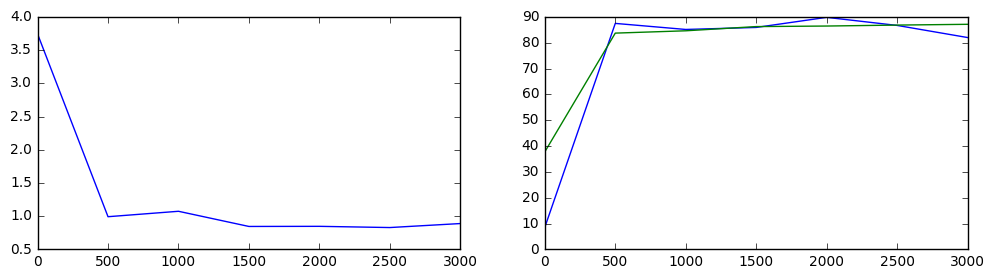

In [34]:
plot_training_nums(run_big_nn_graph(
    [1024, 1024], 
    l2_beta=0.0003,
    input_keep_prob=0.8,
    hidden_keep_prob=0.5,
    starter_learning_rate=0.5, 
    decay_rate=0.96, 
    decay_steps=2048))

hidden layer 0 will have weight dimensions [784, 1024]
hidden layer 1 will have weight dimensions [1024, 1024]
0 0.49999 18.0 | 500 0.49503 84.0 | 1000 0.49012 84.8 | 1500 0.48526 85.3 | 2000 0.48045 86.4 | 2500 0.47569 86.6 | 3000 0.47097 86.9 | 
Test accuracy: 93.2%


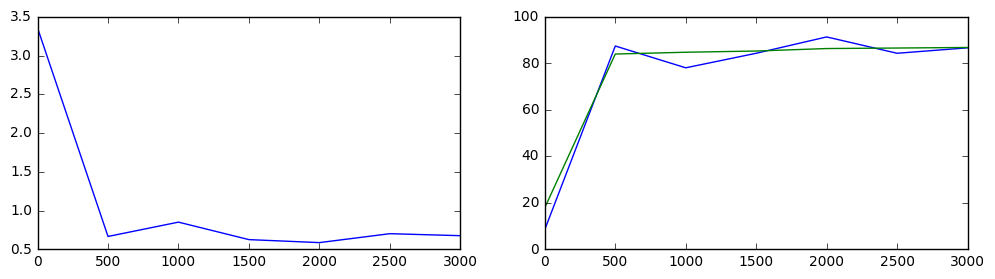

In [35]:
plot_training_nums(run_big_nn_graph(
    [1024, 1024], 
    l2_beta=0.0001,
    input_keep_prob=0.8,
    hidden_keep_prob=0.5,
    starter_learning_rate=0.5, 
    decay_rate=0.96, 
    decay_steps=2048))

I just haven't been able to get good performance with dropout. Let's try some other l2 beta values. 

hidden layer 0 will have weight dimensions [784, 1024]
hidden layer 1 will have weight dimensions [1024, 1024]
0 0.49999 24.1 | 500 0.49503 86.7 | 1000 0.49012 87.0 | 1500 0.48526 88.4 | 2000 0.48045 88.8 | 2500 0.47569 89.1 | 3000 0.47097 89.4 | 
Test accuracy: 95.3%


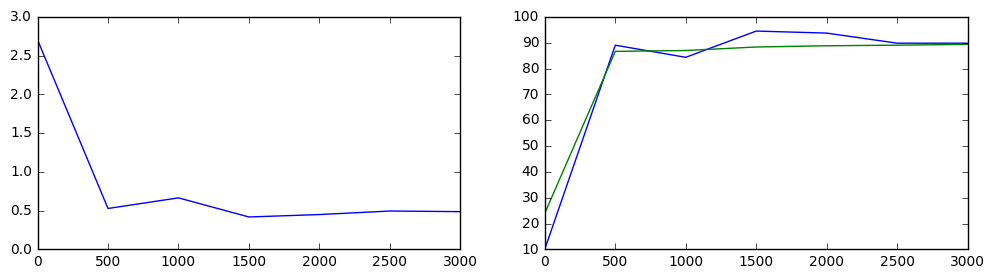

In [36]:
plot_training_nums(run_big_nn_graph(
    [1024, 1024], 
    l2_beta=0.0001,
    starter_learning_rate=0.5, 
    decay_rate=0.96, 
    decay_steps=2048))

So far that is my best run. This sucks because dropout should give better results. Let's try one more l2 beta value.

hidden layer 0 will have weight dimensions [784, 1024]
hidden layer 1 will have weight dimensions [1024, 1024]
0 0.49999 18.4 | 500 0.49503 86.5 | 1000 0.49012 87.5 | 1500 0.48526 88.5 | 2000 0.48045 89.2 | 2500 0.47569 89.2 | 3000 0.47097 89.1 | 
Test accuracy: 95.1%


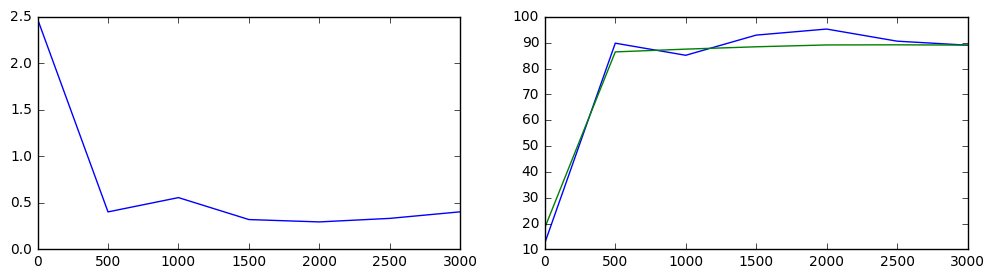

In [37]:
plot_training_nums(run_big_nn_graph(
    [1024, 1024], 
    l2_beta=0.00003,
    starter_learning_rate=0.5, 
    decay_rate=0.96, 
    decay_steps=2048))

hidden layer 0 will have weight dimensions [784, 1024]
hidden layer 1 will have weight dimensions [1024, 1024]
0 0.49996 18.7 | 500 0.48042 86.5 | 1000 0.46165 87.4 | 1500 0.44360 88.7 | 2000 0.42627 89.0 | 2500 0.40961 89.2 | 3000 0.39360 89.6 | 
Test accuracy: 95.4%


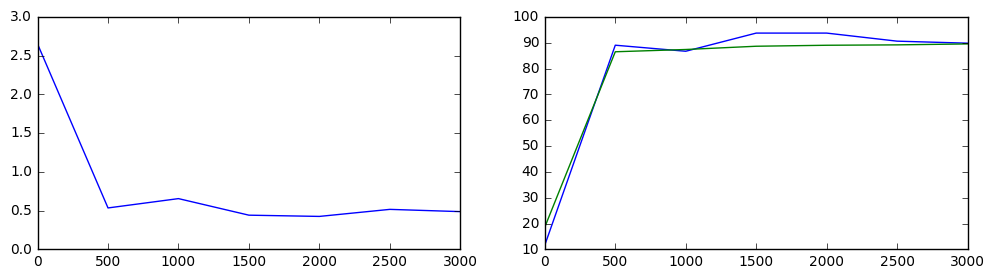

In [38]:
plot_training_nums(run_big_nn_graph(
    [1024, 1024], 
    l2_beta=0.0001,
    starter_learning_rate=0.5, 
    decay_rate=0.96, 
    decay_steps=512))